## Recurrent Neural Networks

Author: Calvin Chan 

### Introduction 

In this final notebook we will look at an advance model known as Recurrent Neural Networks or RNNs. We will be utilizing Gated Reccurent Units or (GRUs) in our model. Since our data consists of time series, we expect RNNs to work much better since they are meant for processing data such as ours. First we will import our full data set and add some minor changes such as reducing the data from multiclass to binary classification. 

At the end of this notebook, we incldued a summary to go through how our model helps with the problem space we are in, what are some of the limitations that we encountered, and possible some next steps if this process were on going. 

### Table of Contents
- [Full Data Import](#import)
- [Data Preprocessing](#preprocessing)
- [First Model](#first)
- [Second Model](#model2)
- [GridSearch](#gridsearch)
- [Summary](#summary)

Let's begin by importing our required packages.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import joblib
import load_functions as f
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization, LeakyReLU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append('..')
from Notebooks import ecg_cleaning as c

<a id='import'></a>
### Full Data Import

We will read in our full data set now.

In [2]:
# File Path
path = '../data/physionet.org/files/ptb-xl/1.0.3/'
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# Import data
full_data = f.load_signal(path, metadata)

In [3]:
# Data shape
full_data[0].shape, full_data[1].shape

((15677, 1000, 12), (15677,))

In [4]:
# Only looking at Lead II

X = full_data[0][:,:,1]

y = full_data[1]

X.shape, y.shape

((15677, 1000), (15677,))

<a id='preprocessing'></a>
### Data Preprocessing 

We need to do some preprocessing of our data, that is using our function in `load_functions.py` to make the target classes binary. Then using our functions for ECG cleaning (`ecg_cleaning.py`), we denoise them before they are fed into respective models. 



#### Binary Classification

In [5]:
# Transform our target column into binary classes
y = y.apply(lambda x: f.binary(x))

In [6]:
# Sanity check
y.value_counts()

ABNO    8645
NORM    7032
Name: diagnostic_superclass, dtype: int64

With the number of classes defined, we have to label them using numbers before we can feed them into models. We do this using `LabelEncoder` from scikit-learn. 

In [7]:
# Instantiate LabelEncoder
label = LabelEncoder()

# Fit target column
label.fit(y)

# Transform target column 
y = label.transform(y)

In [8]:
# Checking how our label is encoded 
label.transform(['ABNO', 'NORM'])

array([0, 1])

#### Signal Denoising using `ecg_cleaning.py`

Here, we denoise our signal using functions we created that implements Fourier Tranforms for signal cleaning. We have to specify frequencies in which we want to take out for baseline wandering and high frequencies, including powerline interference. 

In [9]:
# Low sampling frequency
sig_len = 1000
sampling_frequency = 100
time = np.arange(0, sig_len) / sampling_frequency

# Baseline and PLI removal

signal_bl = np.apply_along_axis(c.baseline_removal, axis=1, arr=X, freq_start=0.1, freq_stop=1.5)
signal_pli = np.apply_along_axis(c.high_freq_removal, axis=1, arr=signal_bl, freq_start=40)

For the model to work properly, it requires our time series signals in a 3D shape. Therefore, we reshape our data. 

In [10]:
# Reshape it into 3D 
signal_pli = signal_pli.reshape(-1, 1000, 1).astype("float")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(signal_pli, y, test_size=0.2, stratify=y, random_state=42)

X_train.shape, y_train.shape

((12541, 1000, 1), (12541,))

In [12]:
X_test.shape, y_test.shape

((3136, 1000, 1), (3136,))

<a id='first'></a>
### First Model 

In this first model, we will use a softmax output layer and sparse categorical cross entropy.

In [14]:
rnn_model = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(2, activation='softmax')],
)

2024-04-17 12:27:17.144549: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.01),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

Setting our early stop and training the model. 

In [16]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=10, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 192s 537ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.5432 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.5267
Epoch 2/10
353/353 [==============================] - 207s 587ms/step - loss: 0.6683 - sparse_categorical_accuracy: 0.5732 - val_loss: 1.0048 - val_sparse_categorical_accuracy: 0.5482
Epoch 3/10
353/353 [==============================] - 221s 627ms/step - loss: 0.6142 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.6871 - val_sparse_categorical_accuracy: 0.5347
Epoch 4/10
353/353 [==============================] - 199s 564ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.8045 - val_sparse_categorical_accuracy: 0.5251
Epoch 5/10
353/353 [==============================] - 200s 567ms/step - loss: 0.5562 - sparse_categorical_accuracy: 0.7143 - val_loss: 0.8139 - val_sparse_categorical_accuracy: 0.5506
Epoch 6/10
 14/353 [>.............................] - ETA: 2:59 - loss: 0.5473 -

KeyboardInterrupt: 

In [131]:
rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 1000, 16)          912       
                                                                 
 batch_normalization_36 (Bat  (None, 1000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 1000, 16)          0         
                                                                 
 gru_25 (GRU)                (None, 16)                1632      
                                                                 
 batch_normalization_37 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_37 (Dropout)        (None, 16)              

In [136]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["sparse_categorical_accuracy"][3]
result = rnn_model.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8058
Test Accuracy: 0.8010


Looking at our training and testing accuracy we see that using RNNs broke us through into the +80% range. This is a great milestone for us. Let's do some more evaluation. 

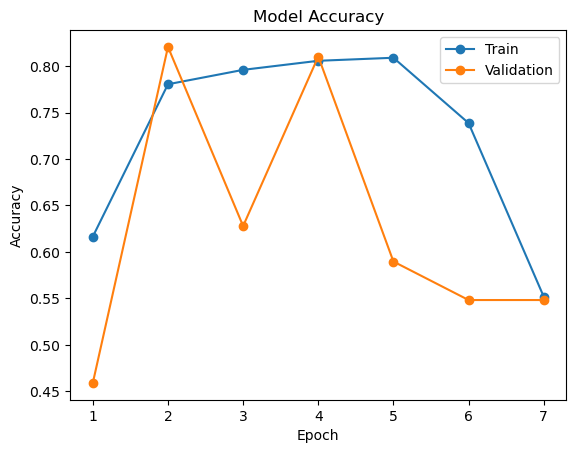

In [155]:
epochs = range(1, 8)

# Plotting accuracy function 
plt.plot(epochs, history.history['sparse_categorical_accuracy'], marker='o')
plt.plot(epochs, history.history['val_sparse_categorical_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

We see that the validation accuracy fluctuates up and down while the training accuracy has a clear increase and then a decrease. Given that we allowed for restoring the best weights using the `restore_best_weights` parameter in our callbacks, our model currently holds the best weight from all the epochs so far. 

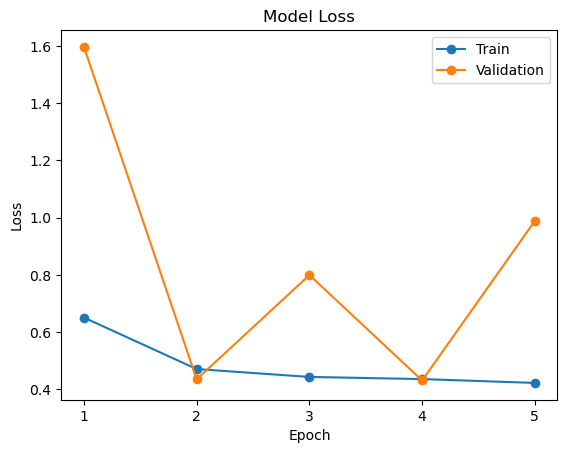

In [156]:
# Plotting loss function 
plt.plot(epochs, history.history['loss'], marker='o')
plt.plot(epochs, history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

Reflecting a similar pattern as accuraacy, the loss score also fluctuates while the training score steadily decreases. 

> Only shows for 5 epochs because last two epochs are `NaN`, possibly because of vanishing gradients. If we look at the previous loss values, we see that it appears to hit a plateau, suggesting vanishing loss. 

In [154]:
# Classification report 
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_predict)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1729
           1       0.83      0.70      0.76      1407

    accuracy                           0.80      3136
   macro avg       0.81      0.79      0.79      3136
weighted avg       0.80      0.80      0.80      3136



Looking at the classification report, we also see that actually `ABNO` ECGs have a pretty high recall, which is good for us since we want to catch those that may have even a small chance of having an abnormal heart rhythm. This is beneficial for many patients and can be applicable to smart watch devices. 

Now we can look into the confusion matrix. 

In [149]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model.predict(X_test)
y_predict = np.argmax(predict_probas, axis=1)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1525,204
True Normal,420,987


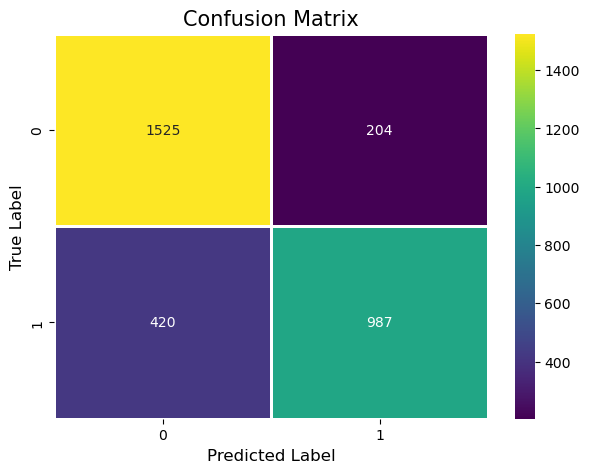

In [179]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

Again looking at our confusion matrix, we can understand why we have a high recall score. Looking at the true labels that are 0, aka `ABNO`, our model seems to have caught a majority of them.

Finally, looking into the ROC curve and AUC score. 

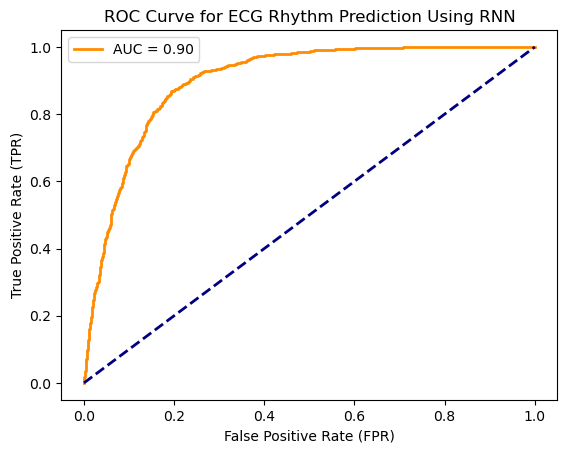

Area under curve (AUC):0.9013817140851144



In [184]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 1])
roc_auc = roc_auc_score(y_test, predict_probas[:, 1])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Our high AUC score is suggestive that our model is great at predicting normal ECGs being actually normal and abnormal ECGs being actually abnormal. This gives us confidence that our model is representing our data well. 

We will document down our models as we go. 

| Model | Activation             | Loss | LR    | Train Accuracy | Test Accuracy | AUC |
|-------|------------------------|------|-------|----------------|---------------|-----|
| 1     | relu, softmax          | SCCE | 0.01  | 80.58          | 80.10         | 90  |

#### Save model as pickle

- https://edwarda-johnson.medium.com/ai-as-ghostwriter-different-ways-to-save-your-machine-learning-model-f8d4432e893

We can save our models as pickle files for using them to predict in the future using the following code below. 

In [185]:
with open('rnn_binary2.pkl', 'wb') as file:
    pickle.dump(rnn_model, file)

2024-04-12 02:18:25.022445: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ec41f544-4f6b-4245-80e0-bc216df8a94b/assets


To reload our model, we can use the following code: 

In [4]:
new_model = open('rnn_binary.pkl', 'rb')
new_rnn_model = pickle.load(new_model)

2024-04-12 13:41:32.244563: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='model2'></a>
### Second Model

Moving on to model two, in this next model, we make appropriate adjustments to a few parameters to allow a better performing model. The following changes include:
- **Loss function**: `SparseCategoricalCrossentropy()` -> `BinaryCrossentropy()`
- **Metric**: `SparseCategoricalAccuracy()` -> `BinaryAccuracy()` 
- **Learning Rate**: `0.01` -> `0.005`
- **Output layer**: `softmax` -> `sigmoid`

The main difference in this model is using a sigmoid activation function and binary crossentropy. 

In [17]:
rnn_model_2 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(1, activation='sigmoid')],
)

In [18]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_2.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.Recall()]
)

Training our neural network with our data set now. 

In [19]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Fit our model, adding a validation set as well 
history = rnn_model_2.fit(X_train, 
                    y_train, 
                    batch_size=32,
                    epochs=10, 
                    validation_split=0.1,
                    callbacks=[callbacks]
)

Epoch 1/10
353/353 [==============================] - 183s 509ms/step - loss: 0.7111 - binary_accuracy: 0.5358 - recall: 0.3389 - val_loss: 0.6934 - val_binary_accuracy: 0.5004 - val_recall: 0.1217
Epoch 2/10
353/353 [==============================] - 184s 520ms/step - loss: 0.5728 - binary_accuracy: 0.6940 - recall: 0.6681 - val_loss: 0.5349 - val_binary_accuracy: 0.7339 - val_recall: 0.5256
Epoch 3/10
353/353 [==============================] - 183s 520ms/step - loss: 0.4614 - binary_accuracy: 0.7897 - recall: 0.7936 - val_loss: 1.0400 - val_binary_accuracy: 0.5769 - val_recall: 0.9965
Epoch 4/10
353/353 [==============================] - 178s 504ms/step - loss: 0.4331 - binary_accuracy: 0.8074 - recall: 0.8149 - val_loss: 0.5347 - val_binary_accuracy: 0.7163 - val_recall: 0.4109
Epoch 5/10
353/353 [==============================] - 176s 500ms/step - loss: 0.4121 - binary_accuracy: 0.8192 - recall: 0.8225 - val_loss: 0.4185 - val_binary_accuracy: 0.8183 - val_recall: 0.9065
Epoch 6/10

In [20]:
rnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1000, 16)          912       
                                                                 
 batch_normalization_3 (Batc  (None, 1000, 16)         64        
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 1000, 16)          0         
                                                                 
 gru_3 (GRU)                 (None, 16)                1632      
                                                                 
 batch_normalization_4 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 16)               

In [21]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmin(history.history['val_loss'])]
result = rnn_model_2.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8235
Test Accuracy: 0.8326


This time our accuracy became slightly better for training, our testing accuracy is still relatively the same. 

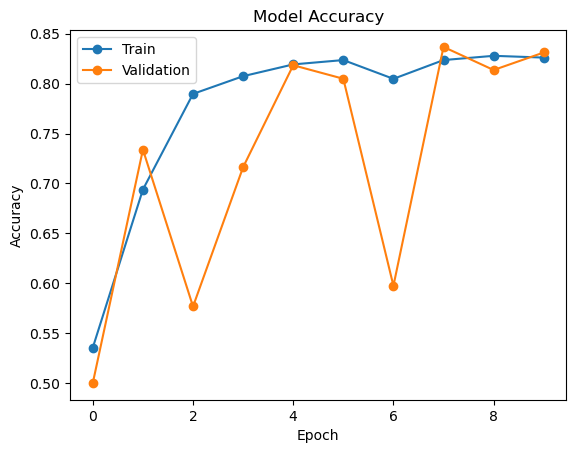

In [22]:
# Plotting accuracy function 
plt.plot(history.history['binary_accuracy'], marker='o')
plt.plot(history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Looking at the model accuracy we see that other than a massive drop in accuracy during one of the epochs, the model has generally been improving along with the training set. At this moment, it is unknown why this drop appears. 

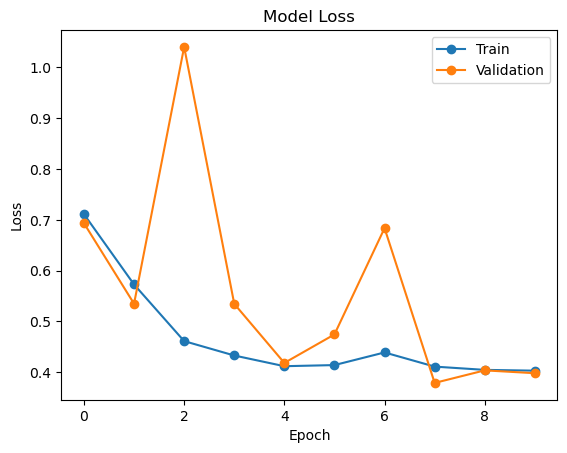

In [23]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

In [24]:
joblib.dump(rnn_model_2, 'new_model_2.pkl')

2024-04-17 14:14:00.226272: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://ada5879e-6483-496b-9101-f75ff0bd1119/assets


['new_model_2.pkl']

In [27]:
rnn_model_2.save('new_model_2.h5')

In [25]:
model = joblib.load('new_model_2.pkl')

In [28]:
print(keras.__version__)

2.7.0


In [26]:
prediction = model.predict(signals.reshape(-1, 1000, 1).astype("float"))
prediction

NameError: name 'signals' is not defined

Again showing the major increase in validation score, it is still unknown where this comes from. However, in other areas of the graph, there has been steady improvements in the loss. 

Below we actually document a few more models that were ran that got overwritten by other code. We keep track of the activation functions used, loss, learning rate, and training and testing accuracy. 

| Model | Activation             | Loss | LR    | Train Accuracy | Test Accuracy | AUC | File   |
|-------|------------------------|------|-------|----------------|---------------|-----|--------|
| 1     | relu, softmax          | SCCE | 0.01  | 80.58          | 80.10         | 90  | model  |
| 2     | relu, sigmoid, softmax | SCCE | 0.01  | 71.29          | 74.90         | --- | ------ | 
| 3     | relu, sigmoid          | SCCE | 0.005 | 81.24          | 82.53         | 70  | model2 |
| 4     | relu, sigmoid          | BCE  | 0.005 | 82.01          | 80.74         | 88  | model3 |

Next, looking into the confusion matrix.

In [50]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_2.predict(X_test)
binary_array = (predict_probas > 0.5).astype(int).reshape(-1) # Binary classification requires only has 1 output

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,1392,337
True Normal,267,1140


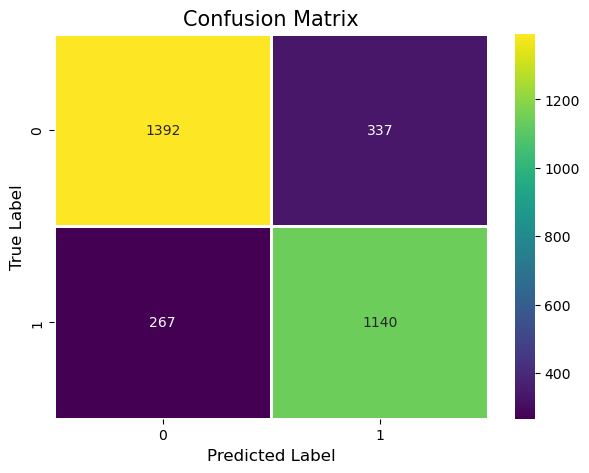

In [52]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [93]:
from sklearn.metrics import classification_report
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.92      0.84      1729
           1       0.87      0.65      0.75      1407

    accuracy                           0.80      3136
   macro avg       0.82      0.79      0.79      3136
weighted avg       0.81      0.80      0.80      3136



Looking at our confusion matrix and classification report above, we see incredibly high scores for recall on the abnormal samples. Again this is great for us as we want our model to be sensitive of these smallest possibility for having an abnormal ECG. Test accuracy scores remain the same, suggesting that we can choose between models depending on our preference.

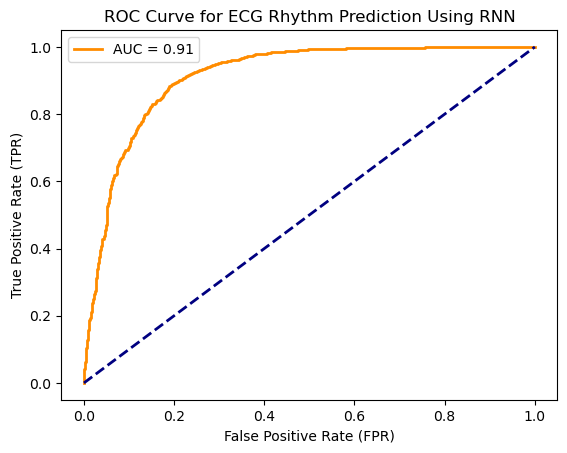

Area under curve (AUC):0.9136454388390198



In [97]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

AUC scores are also really high, giving us confidence that we can classify signals correctly. 

Let's save this model as well.

In [59]:
with open('rnn_binary3.pkl', 'wb') as file:
    pickle.dump(rnn_model_2, file)

2024-04-13 21:59:21.864869: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://33f18296-d1c6-4f32-9fdf-35d2127231de/assets


<a id='gridsearch'></a>
### Using GridSearchCV

Now we attempt to perform a gridsearch. Below we use a gridsearch to try to look for the best performing model parameters. We utilize another package known as `scikeras`. 

In [16]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Setting random seed for reproducibility
tf.random.set_seed(42)

`scikeras` has a specific format for using `GridSearchCV` with, we will follow the guide outlined [here](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) for different parameter optimizations. First we need to create a function that creates our neural network when called upon. 

In [73]:
def create_model():
    
    # Create model
    model = keras.Sequential()
    # the intermediate recurrent layers should return full sequences
    model.add(GRU(16, activation='relu', input_shape=(1000, 1), return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # the last recurrent layer only returns the final output
    model.add(GRU(16, activation='relu', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))

    # output layer
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
    )
    
    return model

We set our callback requirements and parameter grid. 

In [74]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Set our parameter grid with different batch sizes, epochs and learning rate
param_grid = dict(batch_size=[32, 64, 128], 
                  epochs=[10, 25], 
                  optimizer__learning_rate=[0.001, 0.005, 0.01])

# Create an instance of the KerasClassifier to be used in GridSearchCV
models = KerasClassifier(model=create_model, validation_split=0.1)

Next, we initialize the grid itself and fit it to our training data. 

In [75]:
# Initialize grid
grid = GridSearchCV(estimator=models, param_grid=param_grid, cv=3, verbose=3)

# Fit grid
grid_result = grid.fit(X_train, y_train)

Epoch 1/10
236/236 [==============================] - 128s 525ms/step - loss: 0.7327 - binary_accuracy: 0.5279 - val_loss: 0.6937 - val_binary_accuracy: 0.5371
Epoch 2/10
236/236 [==============================] - 126s 536ms/step - loss: 0.6563 - binary_accuracy: 0.5805 - val_loss: 0.6641 - val_binary_accuracy: 0.5526
Epoch 3/10
236/236 [==============================] - 123s 521ms/step - loss: 0.6235 - binary_accuracy: 0.6091 - val_loss: 0.6314 - val_binary_accuracy: 0.5789
Epoch 4/10
236/236 [==============================] - 125s 529ms/step - loss: 0.5281 - binary_accuracy: 0.7341 - val_loss: 0.5885 - val_binary_accuracy: 0.7117
Epoch 5/10
236/236 [==============================] - 121s 513ms/step - loss: 0.4675 - binary_accuracy: 0.7790 - val_loss: 0.5738 - val_binary_accuracy: 0.7344
Epoch 6/10
236/236 [==============================] - 124s 524ms/step - loss: 0.4520 - binary_accuracy: 0.7852 - val_loss: 0.8515 - val_binary_accuracy: 0.6495
Epoch 7/10
236/236 [====================

131/131 [==============================] - 12s 86ms/step
Epoch 1/10
236/236 [==============================] - 126s 526ms/step - loss: 0.7080 - binary_accuracy: 0.5416 - val_loss: 0.6793 - val_binary_accuracy: 0.5663
Epoch 2/10
236/236 [==============================] - 122s 518ms/step - loss: 0.5670 - binary_accuracy: 0.7031 - val_loss: 2.3194 - val_binary_accuracy: 0.4265
Epoch 3/10
236/236 [==============================] - 120s 509ms/step - loss: 0.4752 - binary_accuracy: 0.7751 - val_loss: 0.8977 - val_binary_accuracy: 0.6081
Epoch 4/10
236/236 [==============================] - 120s 510ms/step - loss: 0.4522 - binary_accuracy: 0.7925 - val_loss: 0.6120 - val_binary_accuracy: 0.7037
Epoch 5/10
236/236 [==============================] - 121s 513ms/step - loss: 0.4380 - binary_accuracy: 0.7977 - val_loss: 0.5398 - val_binary_accuracy: 0.6977
Epoch 6/10
236/236 [==============================] - 120s 509ms/step - loss: 0.4242 - binary_accuracy: 0.8107 - val_loss: 0.5075 - val_binary_

236/236 [==============================] - 116s 494ms/step - loss: 0.4122 - binary_accuracy: 0.8170 - val_loss: 0.3882 - val_binary_accuracy: 0.8268
Epoch 11/25
236/236 [==============================] - 116s 492ms/step - loss: 0.4086 - binary_accuracy: 0.8232 - val_loss: 0.7864 - val_binary_accuracy: 0.6679
Epoch 12/25
236/236 [==============================] - 116s 492ms/step - loss: 0.4008 - binary_accuracy: 0.8270 - val_loss: 0.4017 - val_binary_accuracy: 0.8172
Epoch 13/25
236/236 [==============================] - 117s 496ms/step - loss: 0.4067 - binary_accuracy: 0.8203 - val_loss: 0.3603 - val_binary_accuracy: 0.8399
Epoch 14/25
236/236 [==============================] - 116s 492ms/step - loss: 0.4002 - binary_accuracy: 0.8270 - val_loss: 0.5224 - val_binary_accuracy: 0.7563
Epoch 15/25
236/236 [==============================] - 117s 496ms/step - loss: 0.4022 - binary_accuracy: 0.8250 - val_loss: 0.5133 - val_binary_accuracy: 0.7455
Epoch 16/25
236/236 [=========================

Epoch 11/25
236/236 [==============================] - 116s 493ms/step - loss: 0.4175 - binary_accuracy: 0.8122 - val_loss: 0.5685 - val_binary_accuracy: 0.6894
Epoch 12/25
236/236 [==============================] - 116s 493ms/step - loss: 0.4165 - binary_accuracy: 0.8119 - val_loss: 0.3832 - val_binary_accuracy: 0.8208
Epoch 13/25
236/236 [==============================] - 117s 494ms/step - loss: 0.4118 - binary_accuracy: 0.8175 - val_loss: 0.4770 - val_binary_accuracy: 0.7670
Epoch 14/25
236/236 [==============================] - 116s 490ms/step - loss: 0.4086 - binary_accuracy: 0.8153 - val_loss: 0.6846 - val_binary_accuracy: 0.6523
Epoch 15/25
236/236 [==============================] - 116s 491ms/step - loss: 0.4045 - binary_accuracy: 0.8218 - val_loss: 0.5583 - val_binary_accuracy: 0.6977
Epoch 16/25
236/236 [==============================] - 117s 494ms/step - loss: 0.4474 - binary_accuracy: 0.7949 - val_loss: 0.8977 - val_binary_accuracy: 0.5412
Epoch 17/25
236/236 [=============

236/236 [==============================] - 118s 501ms/step - loss: 0.4161 - binary_accuracy: 0.8177 - val_loss: 1.1647 - val_binary_accuracy: 0.5735
Epoch 12/25
236/236 [==============================] - 118s 500ms/step - loss: 0.4094 - binary_accuracy: 0.8150 - val_loss: 0.7965 - val_binary_accuracy: 0.5962
Epoch 13/25
236/236 [==============================] - 119s 502ms/step - loss: 0.4108 - binary_accuracy: 0.8222 - val_loss: 0.5521 - val_binary_accuracy: 0.7754
Epoch 14/25
236/236 [==============================] - 119s 505ms/step - loss: 0.4083 - binary_accuracy: 0.8219 - val_loss: 0.4057 - val_binary_accuracy: 0.8076
Epoch 15/25
236/236 [==============================] - 119s 503ms/step - loss: 0.4066 - binary_accuracy: 0.8226 - val_loss: 0.5136 - val_binary_accuracy: 0.7300
Epoch 16/25
236/236 [==============================] - 118s 499ms/step - loss: 0.4137 - binary_accuracy: 0.8143 - val_loss: 0.3884 - val_binary_accuracy: 0.8280
Epoch 17/25
236/236 [=========================

KeyboardInterrupt: 

> The grid search above ended up taking too much time (the above results were cumulated over a 10 hour grid search and it was only 1/3 of the search), as such we stopped it. However, we noted down some models to have performed pretty well, notably in one of the runs we a **validation accuracy of 84.95%**. We will use the parameters for this result to run another grid search. 

Resetting our parameter grid, we want to see how high the accuracy scores can go. As such we perform another gridsearch using cross-validation.

In [100]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=3
)

# Set our parameter grid with different batch sizes, epochs and learning rate
param_grid = dict(batch_size=[32], 
                  epochs=[25], 
                  optimizer__learning_rate=[0.005])

# Create an instance of the KerasClassifier to be used in GridSearchCV
models = KerasClassifier(model=create_model, validation_split=0.1)

Next, we initialize the grid itself and fit it to our training data. 

In [102]:
# Initialize grid
grid = GridSearchCV(estimator=models, param_grid=param_grid, cv=3, verbose=3)

# Fit grid
grid_result = grid.fit(X_train, y_train)

Epoch 1/25
236/236 [==============================] - 134s 556ms/step - loss: 0.7098 - binary_accuracy: 0.5356 - val_loss: 0.6931 - val_binary_accuracy: 0.5371
Epoch 2/25
236/236 [==============================] - 126s 533ms/step - loss: 0.6879 - binary_accuracy: 0.5528 - val_loss: 0.6883 - val_binary_accuracy: 0.5132
Epoch 3/25
236/236 [==============================] - 124s 527ms/step - loss: 0.6720 - binary_accuracy: 0.5683 - val_loss: 0.6814 - val_binary_accuracy: 0.6172
Epoch 4/25
236/236 [==============================] - 124s 524ms/step - loss: 0.5572 - binary_accuracy: 0.7055 - val_loss: 0.5000 - val_binary_accuracy: 0.7464
Epoch 5/25
236/236 [==============================] - 118s 501ms/step - loss: 0.4627 - binary_accuracy: 0.7869 - val_loss: 0.5491 - val_binary_accuracy: 0.7225
Epoch 6/25
236/236 [==============================] - 124s 526ms/step - loss: 0.4440 - binary_accuracy: 0.7996 - val_loss: 0.4987 - val_binary_accuracy: 0.7644
Epoch 7/25
236/236 [====================

In [103]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.777287 using {'batch_size': 32, 'epochs': 25, 'optimizer__learning_rate': 0.005}


In [14]:
rnn_model_4 = keras.Sequential([
    # the intermediate recurrent layers should return full sequences
    GRU(16, activation='relu', return_sequences=True),
    BatchNormalization(),
    Dropout(0.15),

    # the last recurrent layer only returns the final output
    GRU(16, activation='relu', return_sequences=False),
    BatchNormalization(),
    Dropout(0.15),

    # output layer
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(1, activation='sigmoid')],
)

2024-04-15 00:37:24.646759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
# Compile our model with an optimizer, loss function and metric to look at
rnn_model_4.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(learning_rate=0.005),  # learning rate can be adjusted here
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [17]:
# Set callbacks
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          verbose=1, 
                                          restore_best_weights=True,
                                          patience=25
)

# Fit our model, adding a validation set as well 
history = rnn_model_4.fit(X_train, 
                          y_train, 
                          batch_size=32,
                          epochs=25, 
                          validation_split=0.1,
                          callbacks=[callbacks]
)

Epoch 1/25
353/353 [==============================] - 190s 538ms/step - loss: 0.6983 - binary_accuracy: 0.5390 - val_loss: 0.6906 - val_binary_accuracy: 0.5474
Epoch 2/25
353/353 [==============================] - 190s 538ms/step - loss: 0.6756 - binary_accuracy: 0.5662 - val_loss: 1.0253 - val_binary_accuracy: 0.4518
Epoch 3/25
353/353 [==============================] - 182s 516ms/step - loss: 0.6176 - binary_accuracy: 0.6362 - val_loss: 0.5817 - val_binary_accuracy: 0.6701
Epoch 4/25
353/353 [==============================] - 184s 521ms/step - loss: 0.5864 - binary_accuracy: 0.6728 - val_loss: 0.5713 - val_binary_accuracy: 0.7068
Epoch 5/25
353/353 [==============================] - 182s 516ms/step - loss: 0.5616 - binary_accuracy: 0.6980 - val_loss: 0.5859 - val_binary_accuracy: 0.6845
Epoch 6/25
353/353 [==============================] - 182s 514ms/step - loss: 0.5025 - binary_accuracy: 0.7490 - val_loss: 0.5695 - val_binary_accuracy: 0.7227
Epoch 7/25
353/353 [====================

In [18]:
# Evaluate the model using the test data and generate predictions
train_accuracy = history.history["binary_accuracy"][np.argmax(history.history["binary_accuracy"])]
result = rnn_model_4.evaluate(X_test, y_test, verbose=0)
#result = rnn_model.evaluate(np.real(X_test.values.reshape(-1, 1000, 1)), y_test, verbose=0)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

Train Accuracy: 0.8324
Test Accuracy: 0.7459


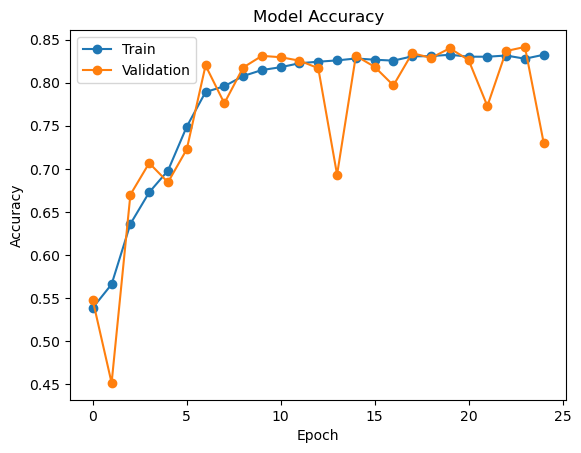

In [25]:
# Plotting accuracy function 
plt.plot(history.history['binary_accuracy'], marker='o')
plt.plot(history.history['val_binary_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

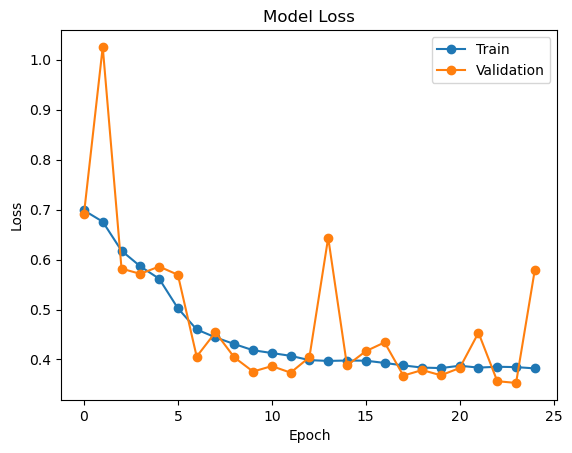

In [27]:
# Plotting loss function 
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.xticks(epochs[:5:1])
plt.legend(['Train', 'Validation'])
plt.show()

From the graphs above, we see major fluctuations in the validation set. The reason for this is still unknown and would be investigated. 

We can look into the confusion matrix and classification report in the mean time. 

In [28]:
# Calculate the predicted labels for each test image.
predict_probas = rnn_model_4.predict(X_test)
binary_array = (predict_probas > 0.5).astype(int).reshape(-1) # Binary classification requires only has 1 output
#y_predict = np.argmax(predict_probas, axis=0)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, binary_array)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Abnormal", "Predicted Normal"],
    index=["True Abnormal", "True Normal"]
)

display(cf_df)

,Predicted Abnormal,Predicted Normal
True Abnormal,943,786
True Normal,11,1396


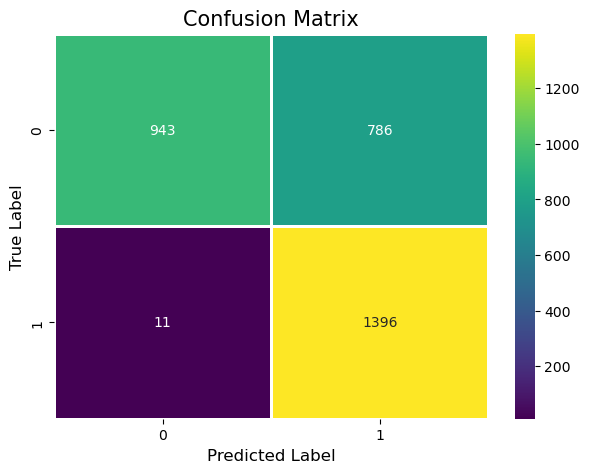

In [29]:
plt.figure(figsize=(7,5))
sns.heatmap(cf_matrix,
            annot=True,
            cbar=True,
            cmap="viridis",
            linewidths=1,
            fmt='d'
)
plt.title('Confusion Matrix', size=15)
plt.xlabel("Predicted Label", size=12)
plt.ylabel("True Label", size=12)
plt.show()

In [32]:
cr = classification_report(y_test, binary_array)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.55      0.70      1729
           1       0.64      0.99      0.78      1407

    accuracy                           0.75      3136
   macro avg       0.81      0.77      0.74      3136
weighted avg       0.83      0.75      0.74      3136



Through the classification report, we actually see decent accuracy scores for the test set as well as high recall score again for the abnormal class. Let's look into the AUC score. 

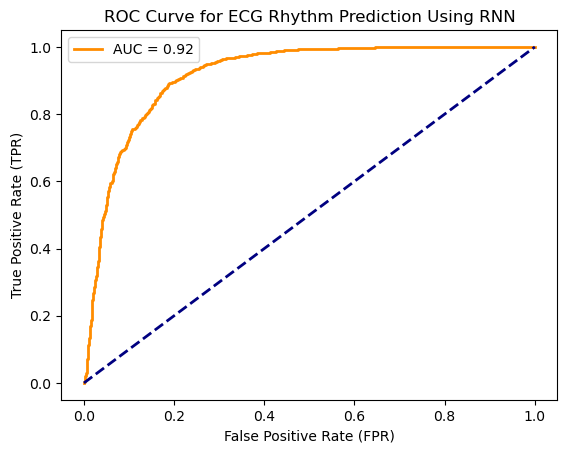

Area under curve (AUC):0.917682512004137



In [35]:
fprs, tprs, thresholds = roc_curve(y_test, predict_probas[:, 0])
roc_auc = roc_auc_score(y_test, predict_probas[:, 0])

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for ECG Rhythm Prediction Using RNN')
plt.legend(loc="best")
plt.savefig('roc_curve.jpg')
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

Another high metric in AUC score, suggesting our model is good at classifying in the respective binary classifications. 

Saving the model

In [36]:
with open('rnn_binary4.pkl', 'wb') as file:
    pickle.dump(rnn_model_4, file)

2024-04-15 04:18:51.387674: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d5d8ebc3-aa1d-4014-8766-e41b4831e169/assets


<a id='summary'></a>
### Summary

Here we will provide a quick recap of our problem space and how our solution will help with the situation. 

Biomedical signals have always played an important role in many medical settings. One of the major type is an ECG, a non invasive procedure that can measure your heart rhythm potentially detecting heart abnormalities and other conditions about your body. However, traditionally, ECGs heavily relied of human interpretation. Medical professionals who may not be adequately trained may misinterpret ECG readings. Even under intense trainings, physicians, such as cardiologist, can also make mistakes too. We propose the solution of using data science tools to help us with identifying ECG signals and classifying them, thereby giving medical professionals a second line of confirmation when they are diagnosing. This can also be extended to the general public, implementing this feature in smart wearable devices, allow users to be notified if they may potentially have certain heart abnormalities given that the wearable device monitors the users heart rhythms in the form of ECGs. 

Starting from the beginning of our journey, we gathered a data set from PhysioNet called PTB-XL that consists of 21799 ECG entries. Since this data set contains signals that possibly have multiple diagnosis at once, we had to be extra careful of which data rows we wanted to train our models on. First, we combined two data sources where one included patient information, and the other the patients ECG diagnosis. This was done in the first notebook, `1 - Metadata_Annotations_Cleaning.ipynb`. We also did some preliminary data cleaning by reducing columns where ones that did not give us immediate useability for our ECG signals, were dropped. 

In the second notebook, `2 - Ecg_Cleaning.ipynb`, we performed some baseline exploratory data analysis by looking at data distributions and statistical tests. Through these tests, we were able to pin down the use case of Fourier Transforms for ECG signal cleaning. By creating functions that would take in a timeseries signal, it would clean a signal by removing noising background frequencies defined by the user. This allowed for better and more precise ECGs to be fed into our models for training, giving improved results. 

In the following notebook, `3 - Baseline_Modeling`, we begin modeling by choosing simple algorithms such as Logistic Regression to see how our data plays. For better modeling, we decided to implement a binning method that let's us bin our signal based on amplitude and see how classification algorithms perform on it. We split our modeling into two ways, multiclass classification or binary classification. In the multiclass method, we fully utilize the extensive coverage of signals that may show multiple heart condition at a time. This ended up with 10 diagnostic superclasses in our target variable. With major class imbalance, modeling with 10 classes became really difficult as our models show. In contrast, using binary classification, greatly increase our model performances leading to positive results. 

As a side detour, we took a chance at autoencoders in the next notebook `4 - Autoencoders`. Autoencoders, utilize a bottle neck in a neural network architecture where information is squeezed extensively forcing the model to only learn about important features of the data before it is asked to reconstruct the original signal. We experimented using our 10 classes and found it difficult to getting the neural network to perform well. Most of the iterations results in underfitting of the validation signal leading to over fitting of the model overall. 

Last but not least, we have our last notebook `5 - Recurrent Neural Networks` where we utilize recurrent neural networks for time series analysis, in our case ECG signals. This time we do not implement the binning method as RNNs process data in sequence, allowing us to feed in the raw data after it has been preprocessed. The results are the best models thus far of all the machine learning algorithms used. However, due to computation inefficiencies, the best model has yet been found through grid search. Although we can confidently say that the RNN models are best are predicting binary classification for our problem space. 

Nowing that heart related problems can change a person in a really short amount of time, we want to make sure that we can catch the issue right away. This is where our models come into play. They are optimized for higher recall score on the abnormal binary class. This means that our algorithm will have a higher chance of alerting someone if they may have the slightest chance of experiencing certain heart abnormalities. This is the goal of our project, to be able to predict ECG conditions acting as the first line of alert. Further implications, such as whether or not the person may about to experience a heart attack or not is left to physicians to determine. 